This notebook presents the code realised for the Homework 2 of the Probabilistic Graphical Models class of MVA

## Setting up the data

In [1]:
# Imports

import numpy as np
from itertools import permutations
import time
import random
from math import *

# For IRIS dataset
from sklearn import datasets
# For data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
# Usefull functions
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance_matrix


# Import the dataset
iris = datasets.load_iris()
X = iris.data
Y = iris.target

In [2]:
# Print some information about the data
print(X.shape, '150 data points in dim 4') 
print(np.mean(X, axis=0), 'Data is not normalized')
print(np.unique(Y))

(150, 4) 150 data points in dim 4
[5.84333333 3.05733333 3.758      1.19933333] Data is not normalized
[0 1 2]


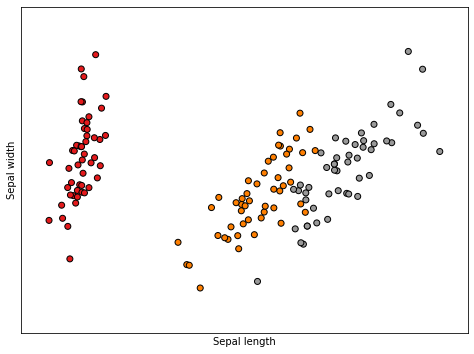

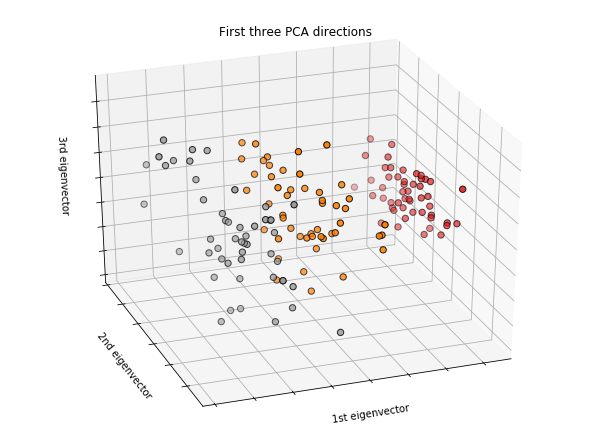

In [3]:
# Visualize the data
# using exemple from https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html


plt.figure(2, figsize=(8, 6))
plt.clf()
X_reduced_2D = PCA(n_components=2).fit_transform(iris.data)
x_min, x_max = X_reduced_2D[:, 0].min() - .5, X_reduced_2D[:, 0].max() + .5
y_min, y_max = X_reduced_2D[:, 1].min() - .5, X_reduced_2D[:, 1].max() + .5
# Plot the training points
plt.scatter(X_reduced_2D[:, 0], X_reduced_2D[:, 1], c=Y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

# Classification: K-means, and the Em algorithm

In [4]:
# Define a function to evaluate the quality of the clustering

def evaluate(clusters, labels, verbose=False):
    '''
    Evaluates the quality of an unsupervised clustering by comparing the clusters to the ground truth labels.
    Makes sure not to rely on the labels themselves: for each possible label of each cluster,
    computes the classification loss. Returns the one for the best labelling found.
    Parameters
    ----------
    clusters: numpy array
        The clusters returned by the clustering algorithm
    labels: numpy array
        The ground truth labels
    Returns
    -------
    The best score between clusters returned by the algorithm and the ground trhuth labels.
    '''
    # Find number maximal number of labels
    clusters = clusters-np.amin(clusters) # make sure index of the first cluster is 0 to avoid errors
    nb_clusters = max(len(np.unique(clusters)), len(np.unique(labels)))
    max_score = 0
    final_cluster_labels = []
    # Function to assign labels on the clusterized data
    assign_clusters_labels = np.vectorize(lambda idx, labels: labels[idx])
    assign_clusters_labels.excluded.add(1)
    # Compute the score for each labelling of the clusters
    for cluster_labels in permutations(range(nb_clusters)):
        labeled_clusters = assign_clusters_labels(clusters, cluster_labels)
        score = accuracy_score(labeled_clusters, labels)
        if score > max_score:
            max_score = score
            final_clusters_labels = cluster_labels
        if verbose:
            print('New cluster labels:', cluster_labels)
            print(score)
    return max_score

#print(evaluate(Y+1, Y, verbose=True))

In [5]:
# Hyper-parameters
nb_steps = 100
initialization = 'kmeans'
nb_clusters = 3

In [6]:
def diag_em_step(X, theta, verbose=False):
    '''
    Performs a step of the diagonal EM algorithm
    Parameters
    ----------
    X: numpy array
        sampled points to be clustered
    theta: tuple
        previous set of parameters. Must be composed of three arrays: p, mu and D of same lenght.
        Assumes D matrices are given as 1D array representing the diagonals
    Returns
    -------
    The set of parameters after an additionnal step of the diagonal EM algorithm
    '''
    p, mu, D = theta
    nb_clusters = len(p)
    D_dets = [np.linalg.det(np.diag(D[i])) for i in range(nb_clusters)]
    
    # Compute A s.t. A(i,k,j)=((x_i-mu_k)_j)^2 (once and for all)
    
    A = np.stack([distance_matrix(X[:,i].reshape(-1,1), mu[:,i].reshape(-1,1)) for i in range(X.shape[1])], axis=-1)
    A = np.square(A) # distance_matrix added an unwanted square root
    
    # Compute tau
    
    # Compare to classical computation
    tau_exp = np.zeros((X.shape[0], p.size))
    for i in range(tau_exp.shape[0]):
        for z in range(tau_exp.shape[1]):
            mat_prod = np.dot(np.transpose(X[i]-mu[z]), np.dot(np.linalg.inv(np.diag(D[z])), (X[i]-mu[z])))
            tau_exp[i,z] = p[z] * (D_dets[z]**(-1/2)) * exp((-1/2)*mat_prod)
    
    D_inv = np.reciprocal(D.astype(float)) # D_k matrices are diagonal so this is tantamount to inverting them
    gaussian_unnorm = np.exp(-0.5*np.einsum('i...j,...j->i...', A, D_inv))
    pre_exp_coefs = p * np.power(np.array(D_dets), -1/2)
    tau_unnorm = np.einsum('i...,...->i...', gaussian_unnorm, pre_exp_coefs)
    tau = np.divide(tau_unnorm, np.sum(tau_unnorm, axis=1).reshape(-1,1))
    
    # Compute new parameters
    
    new_p = np.divide(np.sum(tau, axis=0), X.shape[0])
    norm_factors = np.reciprocal(np.sum(tau, axis=0))
    new_mu = norm_factors.reshape(-1,1) * np.einsum('ij,ik->jk', tau, X)
    new_D_unnorm = np.einsum('i...,i...k->...k', tau, A)
    new_D = np.einsum('...i,...->...i', new_D_unnorm, norm_factors)
    
    if verbose:
        print(X[:5])
        print('mu', mu)
        print('p', p)
        print('D', D)
        print('A', A)
        print('gaussian unnorm', gaussian_unnorm)
        print('D dets', D_dets)
        print('pre_exp coefs', pre_exp_coefs)
        print('tau_exp', tau_exp)
        print('tau_unnorm', tau_unnorm)
        print('tau norm factors', np.sum(tau_unnorm, axis=1))
        print('tau', tau)
        print('New parameters:')
        print('p', new_p)
        print('norm_factors', norm_factors)
        print('mu', new_mu)
        print('D before norm', new_D_unnorm)
        print('D', new_D)
        
    return ((new_p, new_mu, new_D), tau)

In [7]:
# Test the algorithm over several steps and see the evolution of the results

# Initialization

kmeans_clusters = KMeans(n_clusters=nb_clusters, random_state=0).fit(X)
attrib = kmeans_clusters.labels_
params = (np.full((nb_clusters), 1/nb_clusters), kmeans_clusters.cluster_centers_, np.full((nb_clusters, X.shape[1]), 5.))

def diagonal_em(data, nb_clusters, init, nb_steps, verbose=False):
    params = init
    for i in range(nb_steps):
        params, tau = diag_em_step(data, params, verbose)
    attrib = np.argmax(tau, axis=1)
    return params, attrib

params, attrib = diagonal_em(X, nb_clusters, params, nb_steps)
  

In [8]:
# Compute classical EM solution and K-means solution with SKLearn

def k_means_clustering(data, nb_clusters):
    kmeans_clusters = KMeans(n_clusters=nb_clusters).fit(data)
    return(kmeans_clusters.labels_)

def full_em_clustering(data, nb_clusters):
    model = GaussianMixture(n_components=nb_clusters, covariance_type='full')
    return(model.fit_predict(data), model)

k_means_result = k_means_clustering(X, nb_clusters)
full_em_result, full_em_model = full_em_clustering(X, nb_clusters)

Quality of ground truth
1.0
Quality of kmeans
0.8933333333333333
Quality of diagonal EM
0.94
Quality of full EM
0.9666666666666667


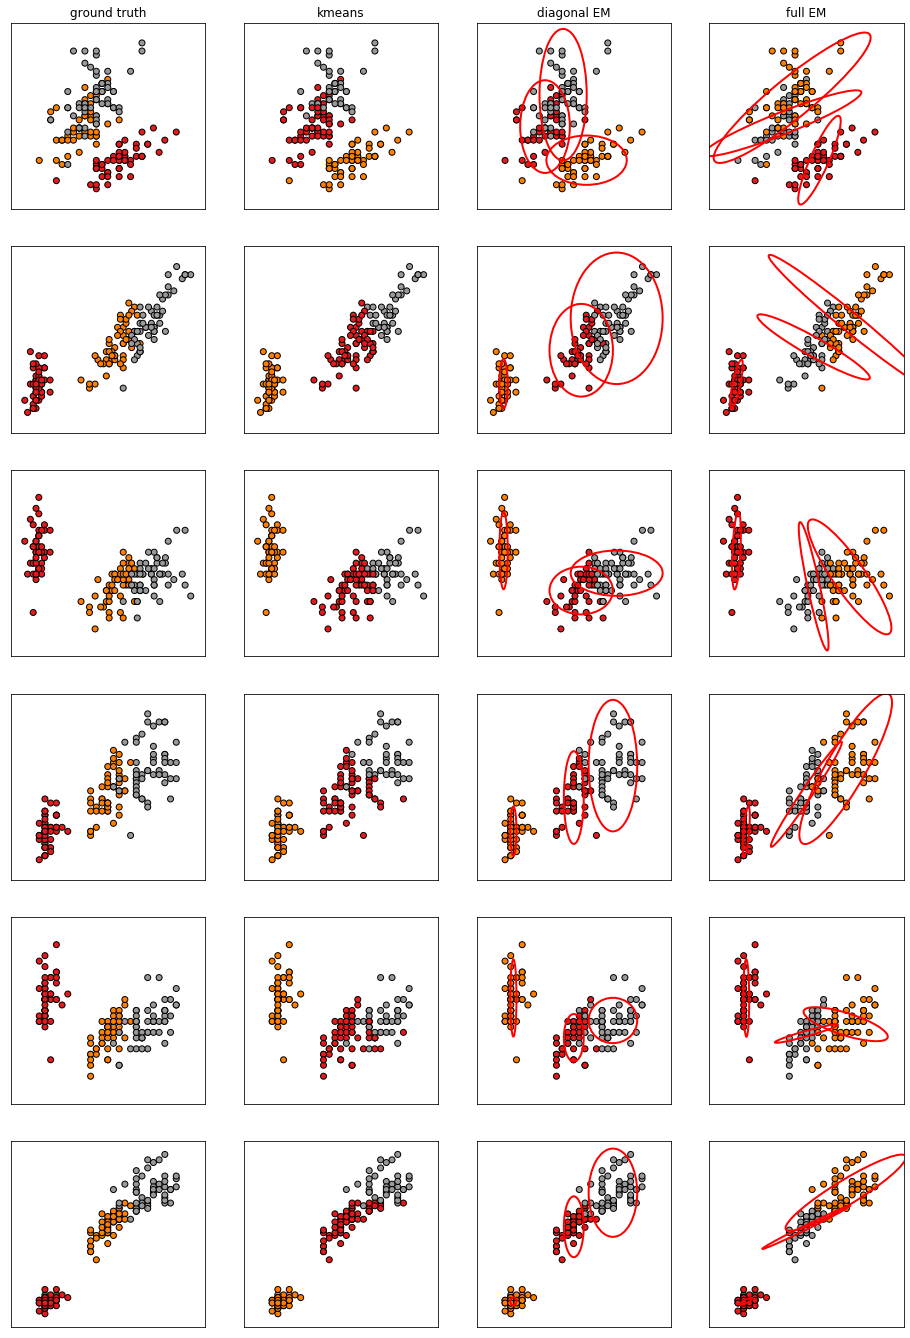

In [9]:

# Visualize pedictions, compare to ground truth

plt.figure(2, figsize=(16, 24))
plt.clf()
x_min, x_max = X_reduced_2D[:, 0].min() - .5, X_reduced_2D[:, 0].max() + .5
y_min, y_max = X_reduced_2D[:, 1].min() - .5, X_reduced_2D[:, 1].max() + .5

titles = ['ground truth', 'kmeans', 'diagonal EM', 'full EM']
label_sets = [Y, k_means_result, attrib, full_em_result]

# Evaluate a quantitative score for the different clustering:
for i in range(len(titles)):
    print('Quality of ' + titles[i])
    print(evaluate(label_sets[i], Y))

# Plotting for every pair of dimetions
n_dims = X.shape[-1]
all_pairs = [(i,j) for i in range(0,n_dims) for j in range(0,i)]

for pair_num, pair in enumerate(all_pairs):

    for i in range(len(titles)):

        # Plot the training points
        plt.subplot(len(all_pairs),len(titles),pair_num*len(titles)+(i+1))
        
        x_min, x_max = X[:, pair[0]].min() - .5, X[:, pair[0]].max() + .5
        y_min, y_max = X[:, pair[1]].min() - .5, X[:, pair[1]].max() + .5
        plt.scatter(X[:, pair[0]], X[:, pair[1]], c=label_sets[i], cmap=plt.cm.Set1, edgecolor='k')

        # Plot the ellipses for diagonal EM
        if titles[i] == 'diagonal EM':
            ax = plt.gca()
            for k in range(nb_clusters):
            
                ellipse = Ellipse(xy=(params[1][k, pair[0]], params[1][k, pair[1]]),
                                  width=10*params[2][k, pair[0]], height=10*params[2][k, pair[1]], 
                                  edgecolor='r', fc='None', lw=2)
                
                ax.add_patch(ellipse)
                
        # Doing the same for full EM requires a bit more work
        if titles[i] == 'full EM':
            ax = plt.gca()
            for k in range(nb_clusters):
                
                local_CovMat = np.take(np.take(full_em_model.covariances_[k], pair, axis=1), pair, axis=0)
                
                eigenvals, eigenvects = np.linalg.eigh(local_CovMat)
                vm, vM = eigenvects
                cos_ = np.clip(np.dot(vM, np.array([1.,0.]))/np.linalg.norm(vM), -1.0, 1.0)
                angle = np.arccos(cos_)
                
                
                ellipse = Ellipse(xy=(full_em_model.means_[k, pair[0]], full_em_model.means_[k, pair[1]]),
                                  width=10*eigenvals[1], height=10*eigenvals[0], angle=angle*180,
                                  edgecolor='r', fc='None', lw=2)
                ax.add_patch(ellipse)
                
        if pair_num==0:
            plt.title(titles[i])
            
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())

#plt.savefig('PGM_HW2_LouisDumont_'+str(nb_clusters)+'clusters.jpg')
plt.show()


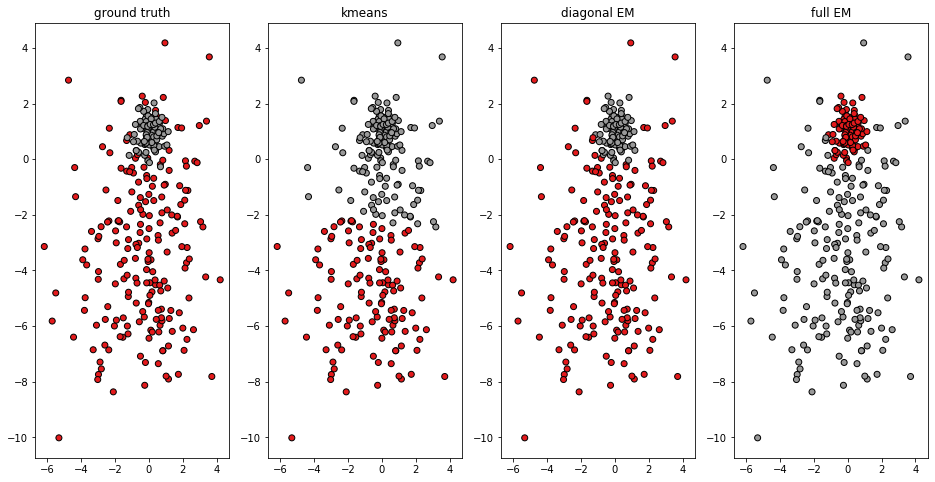

In [10]:
# Illustrating how K-means can be outperformed by EM algorithms


# Generating data
cluster1 = np.random.multivariate_normal(np.array([0,-3]), np.array([[4,0],[0,8]]), 200)
cluster2 = np.random.multivariate_normal(np.array([0,1]), np.array([[0.2,0],[0,0.2]]), 100)

X_ex = np.concatenate((cluster1, cluster2), axis=0)
Y_ex = np.concatenate((np.full(cluster1.shape[0], 0), np.full(cluster2.shape[0], 1)), axis=0)

# Computing the clustering from the different algorithms
clusters_fullEM, _ = full_em_clustering(X_ex, 2)

kmeans_clustering = KMeans(n_clusters=2, random_state=0).fit(X_ex)
clusters_kmeans = kmeans_clustering.labels_

centers = kmeans_clustering.cluster_centers_
params = (np.full((2), 0.5), centers, np.full((2, X_ex.shape[1]), 5.))
params, clusters_diagEM = diagonal_em(X_ex, 2, params, nb_steps)

# Plotting
plt.figure(2, figsize=(16, 8))
plt.clf()
x_min, x_max = X_ex[:, 0].min() - .5, X_ex[:, 0].max() + .5
y_min, y_max = X_ex[:, 1].min() - .5, X_ex[:, 1].max() + .5

titles = ['ground truth', 'kmeans', 'diagonal EM', 'full EM']
label_sets = [Y_ex, clusters_kmeans, clusters_diagEM, clusters_fullEM]

for i in range(len(titles)):
    plt.subplot(1, len(titles), i+1)
    plt.scatter(X_ex[:, 0], X_ex[:, 1], c=label_sets[i], cmap=plt.cm.Set1, edgecolor='k')
    plt.title(titles[i])

#plt.savefig('PGM_HW2_LouisDumont_kmeansLimits2.jpg')

plt.show()

# Graphs, Sum-Product and Junction Tree algorithms, and Ising

In [11]:
# First, implement the su-product algorithm on a chain (forward and backwoard pass)

# node-wise phis are represented as arrays or phi_i(x_i)
    
def forward_log(step, log_phi_u, log_phi_b, prev_messages=None, verbose=False):
    '''
    Computes the messages for a forward pass of the sum-product algorithm.
    
    Parameters
    ----------
    step: int
        Index of the node from which the messages are issued
    log_phi_u: numpy array
        Log-values of the unary potentials. First dimention is the node, second is the state.
    log_phi_b: numpy array
        Log-values of the binary potentials. First dimention is the pair of nodes, second and third the states.
    prev_messages: numpy array or None
        Messages from the previous node (if the node is not a leaf). Each entry corresponds to a node value.
        
    Returns
    -------
    log-messages for the next node, as an numpy array
    '''
    # With log-trick
    res = np.zeros((log_phi_u.shape[1]))
    log_phi_u_loc = log_phi_u[step].copy()
    if verbose: 
        print('log_phi_u loc', log_phi_u_loc)
    if not (prev_messages is None):
        # Adding the previous messages if relevant
        log_phi_u_loc += prev_messages
    for x_end in range(res.size):
        # multiplying phi_u and phi_b
        log_prod = log_phi_u_loc + log_phi_b[step, :, x_end]
        if verbose: 
            print('log_phi_b_loc', log_phi_b[step, :, x_end])
            print('log_prod', log_prod)
        # Finding the maximum over node values
        pivot = np.argmax(log_prod)
        if verbose: 
            print('pivot', pivot)
        # Computing log(sum)
        log_message = log_prod[pivot] + log(np.sum(np.exp(log_prod - log_prod[pivot])))
        if verbose: 
            print('log_message', log_message)
            print('message', np.exp(log_message))
        # Storing result
        res[x_end] = log_message
    return res

def backward_log(step, log_phi_u, log_phi_b, prev_messages=None, verbose=False):
    '''
    Computes the messages for a backward pass of the sum-product algorithm.
    See forward_pass.
    '''
    # With log-trick
    res = np.zeros((log_phi_u.shape[1]))
    log_phi_u_loc = log_phi_u[step].copy()
    if verbose: 
        print('log_phi_u loc', log_phi_u_loc)
    if not (prev_messages is None):
        # Adding the previous messages if relevant
        log_phi_u_loc += prev_messages
    for x_prev in range(res.size):
        # multiplying phi_u and phi_b
        log_prod = log_phi_u_loc + log_phi_b[step-1, x_prev, :]
        if verbose: 
            print('log_phi_b_loc', log_phi_b[step, x_prev, :])
            print('log_prod', log_prod)
        pivot = np.argmax(log_prod)
        if verbose: 
            print('pivot', pivot)
        # Computing log(sum)
        log_message = log_prod[pivot] + log(np.sum(np.exp(log_prod - log_prod[pivot])))
        if verbose: 
            print('log_message', log_message)
            print('message', np.exp(log_message))
        # Storing result
        res[x_prev] = log_message
    return res
        

def chain_sum_product(phi_u, phi_b, compute_backward_log=backward_log, compute_forward_log=forward_log):
    '''
    Computes the forward and backward pass on a chain, returns the messages.
    Everything is expressed as log.
    
    Parameters
    ----------
    phi_u: numpy array
        Values of the unary potentials. First dimention is the node, second is the state
    phi_b: numpy array
        Values of the binary potentials. First dimention is the pair of nodes, second and third the states.
        Differentiate 2 dimensions (1 for the state of each node)
    compute_forward_log, compute_backward_log: functions
        Functions for message passing. Parameterizing it allows for faster computation in specific cases.
        Default is the most general case.
        
    Returns
    -------
    Two arrays, for the forward and backward messages. First dimention is the origin node, second is the state.
    '''
    
    nb_nodes, nb_states = phi_u.shape
    
    log_phi_u = np.log(phi_u)
    log_phi_b = np.log(phi_b)
    
    forward_messages_log = np.full((nb_nodes-1, nb_states), 0.)
    backward_messages_log = np.full((nb_nodes-1, nb_states), 0.)
    
    # Compute the messages at the extremities of the chain
    forward_messages_log[0] = compute_forward_log(0, log_phi_u, log_phi_b)
    backward_messages_log[0] = compute_backward_log(nb_nodes-1, log_phi_u, log_phi_b)
    
    # Forward and backward can be computed in one single loop
    for i in range(1, nb_nodes-1):
        forward_messages_log[i] = compute_forward_log(i, log_phi_u, log_phi_b, forward_messages_log[i-1])
        backward_messages_log[i] = compute_backward_log(nb_nodes-1-i, log_phi_u, log_phi_b, backward_messages_log[i-1])
    return(forward_messages_log, np.flip(backward_messages_log, axis=0))
        
    
# Check implementation
# 3 nodes 2 states grid framework (Ising)
nb_nodes = 3
nb_states = 2
alpha = 0.
beta = 1.

phi_u = np.full((nb_nodes, nb_states), 1).astype(float)
phi_u[:,1] = exp(alpha)
phi_b = np.full((nb_nodes-1, nb_states, nb_states), 1).astype(float)
for i in range(nb_states):
    phi_b[:,i,i] = exp(beta)
    
log_phi_u = np.log(phi_u)
log_phi_b = np.log(phi_b)

log_forward, log_backward = chain_sum_product(phi_u, phi_b)

print(np.exp(log_forward), np.exp(log_backward))

[[ 3.71828183  3.71828183]
 [13.82561976 13.82561976]] [[13.82561976 13.82561976]
 [ 3.71828183  3.71828183]]


In [12]:
# Second, use the algorithm on a chaine-reduced Ising model

nb_nodes = 100
nb_states = 2**10
alpha = 0
beta = 1

phi_u = np.full((nb_nodes, nb_states), exp(alpha))

# Constructing phi_b in a relevant way, leveraging bitwise operations

mat1 = np.array([[i] for i in range(nb_states)], dtype=np.uint16)

# Thsi clever implementation to overcome numpy's limitations was found on
#https://stackoverflow.com/questions/18296035/how-to-extract-the-bits-of-larger-numeric-numpy-data-types
def unpackbits(x,num_bits):
    xshape = list(x.shape)
    x = x.reshape([-1,1])
    to_and = 2**np.arange(num_bits).reshape([1,num_bits])
    return (x & to_and).astype(bool).astype(int).reshape(xshape + [num_bits])

# Contains the bitwise representation of all integers in range(nb_states)
# The bitwise representations of the integers implicitely encode all possible states of the line
# represented by the node, which eases the computation.
bitMat2 = np.squeeze(unpackbits(mat1, 10))

phi_bitwise = np.full((nb_states, nb_states), 0)

for i in range(nb_states):
    bit_rep = bitMat2[i,:]
    logical_or = np.bitwise_or(bitMat2, bit_rep)
    logical_and = np.bitwise_and(bitMat2, bit_rep)
    diff = np.logical_not(logical_or-logical_and)
    phi_bitwise[:,i] = np.sum(diff, axis=1)
# phi_bitwise counts the number of equalities between corresponding nodes

phi_b = np.exp(beta*phi_bitwise)

# As the variables are binary and psi functions do not depend on nodes, we simplify the updates
def ising_pass_log(step, log_phi_u, log_phi_b, prev_messages=None, verbose=False):
    '''
    A simpler implementation of the passes for the Ising model.
    Leverages the spatial stationarity of pairwise potentials to allow for reduced phi_b.
    Parameters
    ----------
    log_phi_b: numpy array
        Log-values of the binary potentials. First dimention is first node's state, second second node's state.
    See forward_log for additionnal documentation
    '''
    nb_states = log_phi_u.shape[1]
    # With log-trick
    res = np.zeros((nb_states))
    log_phi_u_loc = phi_u[step, :].copy()
        
    if verbose: 
        print('log_phi_u loc', log_phi_u_loc)
    if not (prev_messages is None):
        # Adding the previous messages if relevant
        log_phi_u_loc += prev_messages
    for x_end in range(res.size):
        # multiplying phi_u and phi_b
        log_prod = log_phi_u_loc + log_phi_b[:, x_end]
        if verbose: 
            print('log_phi_b_loc', log_phi_b[:, x_end])
            print('log_prod', log_prod)
        # Finding argmax of the sum
        pivot = np.argmax(log_prod)
        if verbose: 
            print('pivot', pivot)
        # Computing log(sum)
        log_message = log_prod[pivot] + log(np.sum(np.exp(log_prod - log_prod[pivot])))
        if verbose: 
            print('log_message', log_message)
            print('message', np.exp(log_message))
        res[x_end] = log_message
    return res


forward_messages, backward_messages = chain_sum_product(phi_u, phi_b, ising_pass_log, ising_pass_log)

# Computing Z from the messages
node = 50 # The result of the computation does not depend on the node
log_proba = np.multiply(np.multiply(forward_messages[node-1], np.log(phi_u[node])), backward_messages[node])
# Summing the log-probabilities over possible values
pivot = np.argmax(log_proba)
log_z = log_proba[pivot] + log(np.sum(np.exp(log_proba - log_proba[pivot])))

In [13]:
beta_values = np.linspace(-5,5,30)
Z_values_1 = []

step = time.time()
node1 = 50 # The result of the computation does not depend on the node

for i, beta in enumerate(beta_values):
    phi_b = np.exp(beta*phi_bitwise)
    forward_messages, backward_messages = chain_sum_product(phi_u, phi_b, ising_pass_log, ising_pass_log)
    
    log_proba = forward_messages[node-1] + np.log(phi_u[node]) + backward_messages[node]
    # Summing the probas over possible values
    pivot = np.argmax(log_proba)
    log_z = log_proba[pivot] + log(np.sum(np.exp(log_proba - log_proba[pivot])))
    Z_values_1.append(log_z)

    
    if i%10 == 0:
        print(i)
        print('time for 10 steps: ' + str(time.time()-step))
        step = time.time()

0
time for 10 steps: 10.148409605026245
10
time for 10 steps: 101.76950025558472
20
time for 10 steps: 102.25277805328369


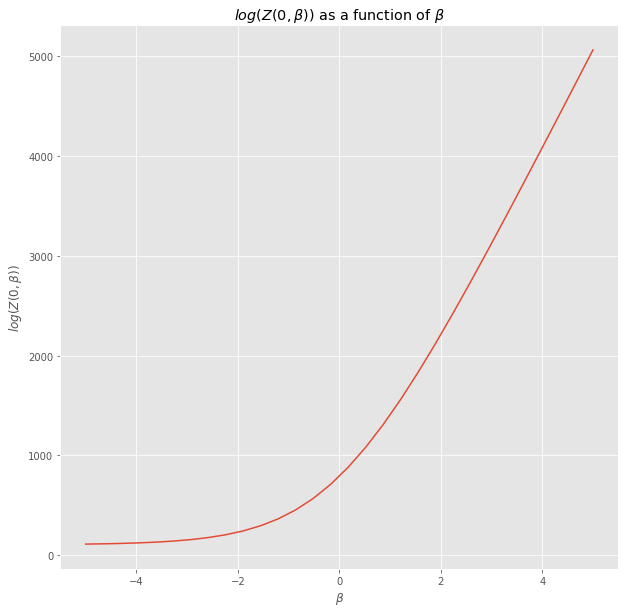

In [14]:
fig = plt.figure(figsize=(10,10))
plt.style.use('ggplot')
plt.plot(beta_values, Z_values_1)
plt.title(r'$log(Z(0, \beta))$ as a function of $\beta$')
plt.ylabel(r'$log(Z(0, \beta))$')
plt.xlabel(r'$\beta$')
plt.savefig('Z_function.jpg')
plt.show()